In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
sns.set_context('poster', font_scale=1.25)

In [6]:
import findspark as fs

In [7]:
fs.init()

In [8]:
import pyspark as ps

In [9]:
import multiprocessing as mp

In [10]:
mp.cpu_count()

12

In [11]:
config = ps.SparkConf()
config = config.setMaster('local[' + str(2*mp.cpu_count()) + ']')
config = config.setAppName('ipython_testing')

In [12]:
sc = ps.SparkContext(conf=config)

In [13]:
import P2

In [14]:
num_pixels = 2000

In [15]:
num_pixels = 2000
rows = sc.range(num_pixels, numSlices=10)
cols = sc.range(num_pixels, numSlices=10)

In [16]:
indices = rows.cartesian(cols)

In [17]:
def mandelbrot_wrapper(row, col):
    x = col/(num_pixels/4.) - 2.
    y = row/(num_pixels/4.) - 2.
    
    return ((row, col), P2.mandelbrot(x, y))


In [18]:
mandelbrot_rdd = indices.map(lambda a: mandelbrot_wrapper(*a))

We now need to turn this into a key-value pair...

In [19]:
mandelbrot_result = mandelbrot_rdd.collect()

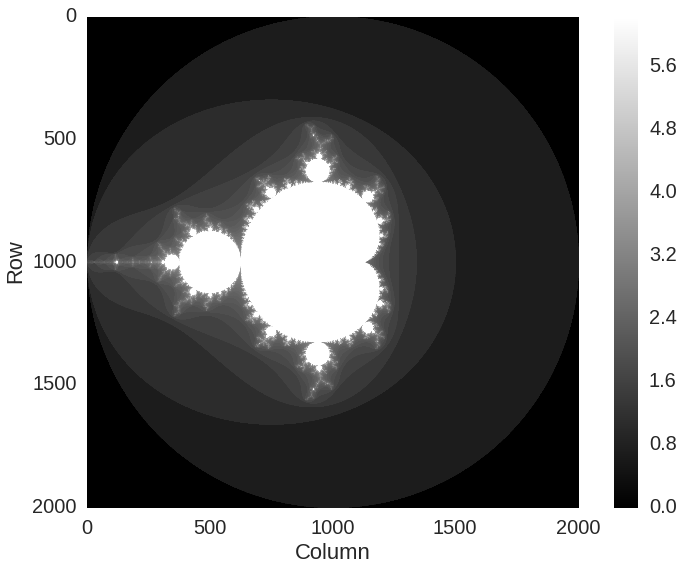

In [70]:
plt.grid(False)
P2.draw_image(data=mandelbrot_result)
plt.colorbar()
plt.xlabel('Column')
plt.ylabel('Row')

Beautiful. We have liftoff! Let's try to make that histogram now. I have now initialized the # of cores correctly, thankfully. How can we get a list of the work done on each partition...?

In [23]:
summed_rdd = P2.sum_values_for_partitions(mandelbrot_rdd)

In [24]:
summed_result = summed_rdd.collect()

In [27]:
len(summed_result)

100

Well, at least that has the correct shape...ok I get it. It sums the number of iterations taken to make this shape in each parition. So, the plot we need is

(array([ 82.,   4.,   0.,   0.,   2.,   0.,   0.,   2.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   2.,   2.,   0.,   2.,   2.]),
 array([        0.,   1022000.,   2044000.,   3066000.,   4088000.,
          5110000.,   6132000.,   7154000.,   8176000.,   9198000.,
         10220000.,  11242000.,  12264000.,  13286000.,  14308000.,
         15330000.,  16352000.,  17374000.,  18396000.,  19418000.,
         20440000.]),
 <a list of 20 Patch objects>)

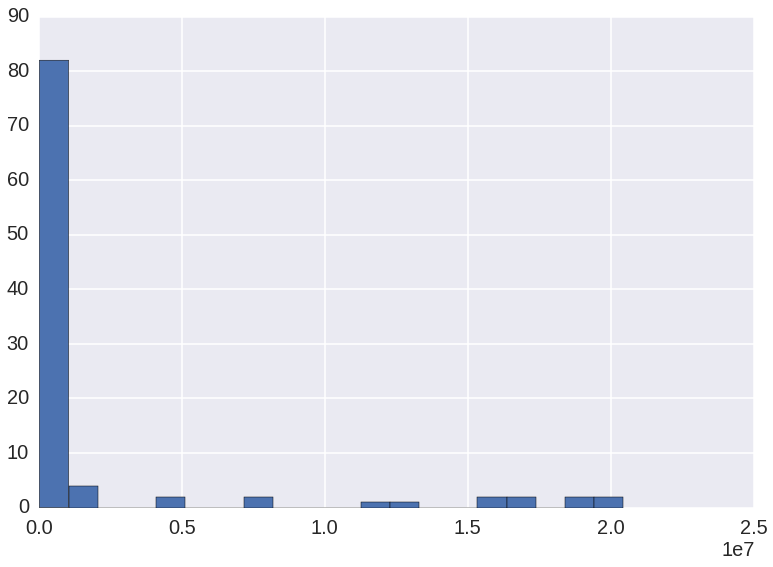

In [29]:
plt.hist(summed_result, bins=20)

We probably need a log scale...

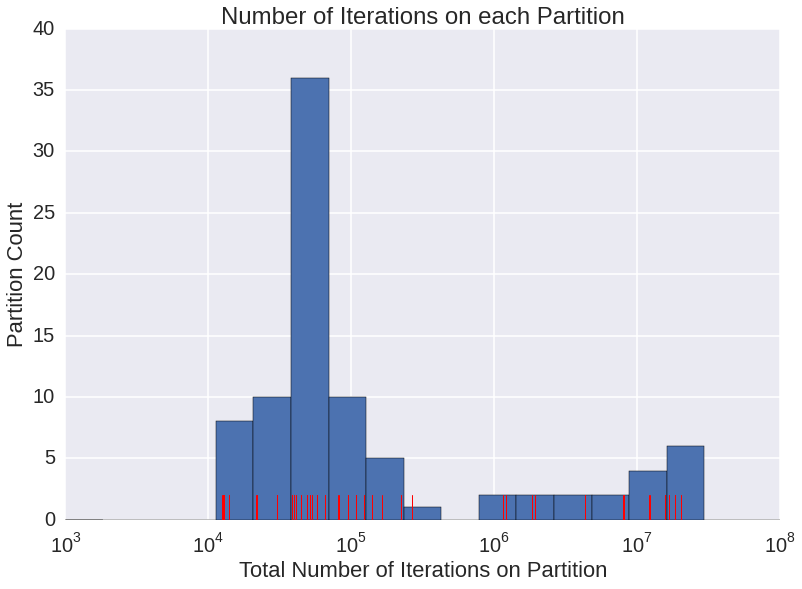

In [57]:
plt.hist(summed_result, bins=np.logspace(3, 8, 20))
sns.rugplot(summed_result, color='red')
plt.gca().set_xscale('log')
plt.xlabel('Total Number of Iterations on Partition')
plt.ylabel('Partition Count')
plt.title('Number of Iterations on each Partition')

Ok. This is instructive. The jobs run over several orders of magnitude. The rugplot is awesome because it gives you a real feeling of how many events there are distributed over space.

# Rebalancing the load

The question is: how do we predict how many iterations will occur for a given x,y? We need to make the load equally balanced across all partitions. We still must use 100 partitions. Is there a way we can predict how many iterations a given x, y will take? 

Not really. It's  a fractal. But we can make some general rules. If we are only load balancing based on row & column position, which is what I expect, we can define a prior-function to control how long we think things will take. Why don't we just make it radial.

In [118]:
predicted_iteration_rdd = indices.map(lambda a: (a, get_predicted_num_iterations(*a)))

It may be easier to just create an array and then grab data from it. Probably use it as a broadcast variable.

In [154]:
import skimage as ski
import skimage.io

In [155]:
expensive_mask = np.zeros((num_pixels, num_pixels))
e_top = 550
e_bottom = 1450
e_left = 300
e_right = 1250

expensive_mask[e_top:e_bottom, e_left:e_right] = 1
expensive_mask[1250:e_bottom, e_left:650]=0
expensive_mask[e_top:750, e_left:650]=0
expensive_mask[990:1010, 0:e_left]=1

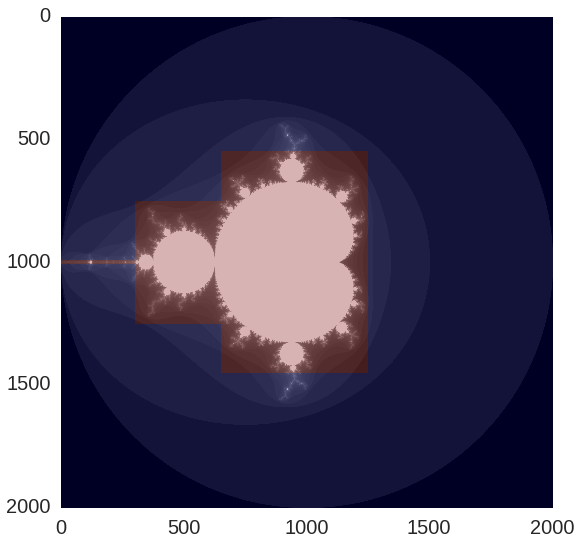

In [153]:
plt.grid(False)
P2.draw_image(data=mandelbrot_result)
ski.io.imshow(expensive_mask, alpha=0.3, cmap=plt.cm.jet)

This should work well. Awesome.

In [164]:
broadcast_expensive = sc.broadcast(expensive_mask)

We need to partition the expensive jobs onto each worker evenly. Let us do that. Let us match each coordinate pair (row, col) to the value if it's expensive.

In [162]:
expensive_mask.ravel()

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [173]:
indices_vs_expensive = indices.map(lambda a: (a, broadcast_expensive.value[a[0], a[1]]))

In [174]:
indices_vs_expensive.take(5)

[((0, 0), 0.0), ((0, 1), 0.0), ((0, 2), 0.0), ((0, 3), 0.0), ((0, 4), 0.0)]

Ok, good. We now know if the computation is expensive or not (defined as 3 orders of magnitude higher than the norm). We now need to distribute the 1's across each partition equally. How do we do this? Ok. I know. We can just get the expensive tasks, act on them, then act on the unexpensive tasks, and merge the results. That is definitely the easiest way.

In [175]:
expensive_tasks = indices_vs_expensive.filter(lambda x: x[1] == 1)

In [177]:
expensive_tasks.take(10)

[((550, 650), 1.0),
 ((550, 651), 1.0),
 ((550, 652), 1.0),
 ((550, 653), 1.0),
 ((550, 654), 1.0),
 ((550, 655), 1.0),
 ((550, 656), 1.0),
 ((550, 657), 1.0),
 ((550, 658), 1.0),
 ((550, 659), 1.0)]

Cool. We now create a RDD of the expensive tasks.

In [181]:
expensive_mandelbrot_rdd = expensive_tasks.map(lambda a: mandelbrot_wrapper(a[0][0], a[0][1]))

In [184]:
expensive_mandelbrot_rdd.take(10)

[((550, 650), 3),
 ((550, 651), 3),
 ((550, 652), 3),
 ((550, 653), 3),
 ((550, 654), 3),
 ((550, 655), 3),
 ((550, 656), 3),
 ((550, 657), 3),
 ((550, 658), 3),
 ((550, 659), 3)]

In [185]:
cheap_tasks = indices_vs_expensive.filter(lambda x: x[1] == 0)

In [187]:
cheap_mandelbrot_rdd = cheap_tasks.map(lambda a: mandelbrot_wrapper(a[0][0], a[0][1]))

In [190]:
cheap_mandelbrot_rdd.take(10)

[((0, 0), 0),
 ((0, 1), 0),
 ((0, 2), 0),
 ((0, 3), 0),
 ((0, 4), 0),
 ((0, 5), 0),
 ((0, 6), 0),
 ((0, 7), 0),
 ((0, 8), 0),
 ((0, 9), 0)]

In [191]:
combined_rdd = expensive_mandelbrot_rdd.union(cheap_mandelbrot_rdd)

In [193]:
load_balanced_mandelbrot_result = combined_rdd.collect()

In [200]:
combined_cheap_expensive_hist = P2.sum_values_for_partitions(combined_rdd)

In [201]:
load_balanced_hist = combined_cheap_expensive_hist.collect()

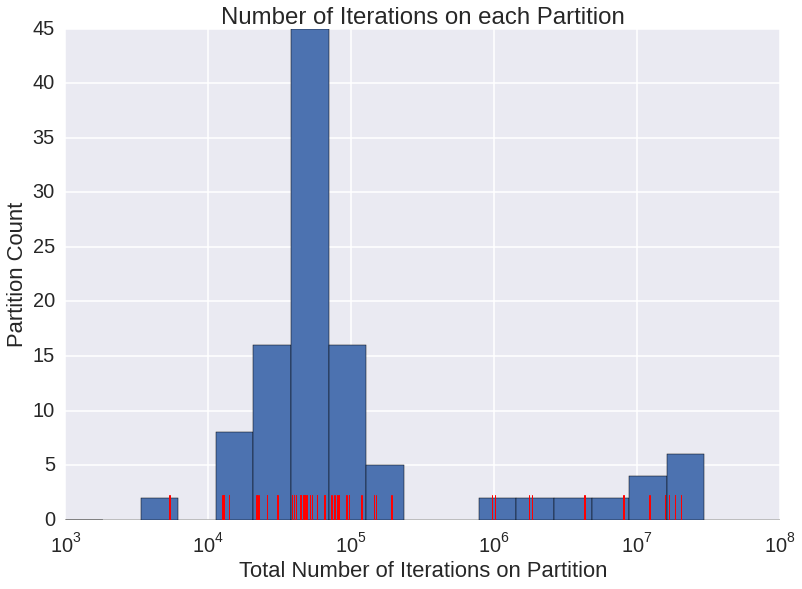

In [203]:
plt.hist(load_balanced_hist, bins=np.logspace(3, 8, 20))
sns.rugplot(load_balanced_hist, color='red')
plt.gca().set_xscale('log')
plt.xlabel('Total Number of Iterations on Partition')
plt.ylabel('Partition Count')
plt.title('Number of Iterations on each Partition')

It was still a failure. Hm. It looks almost identical to before! Things must not be partitioned correctly between workers :(. I have to figure out how to do that...